In [1]:
%autoreload 2

In [27]:
from ast import literal_eval
from collections import defaultdict, Counter
from contextlib import contextmanager
from itertools import combinations, chain
import hashlib
import json
import os
import shelve
from types import SimpleNamespace
import typing


import colorcet as cc
import krippendorff
from IPython.display import display, HTML, Markdown
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from statannotations.Annotator import Annotator
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tabulate import tabulate


import arviz as az
az.style.use("arviz-darkgrid")
from cmdstanpy import CmdStanModel

from sklearn.model_selection import train_test_split


In [3]:
class ExtendedSimpleNamespace(SimpleNamespace):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def __contains__(self, key):
        return hasattr(self, key)

    def __getitem__(self, key):
        return getattr(self, key)

    def get(self, key, default=None):
        return getattr(self, key, default)

    def keys(self):
        return [k for k in vars(self).keys() if not k.startswith("_")]
        

In [4]:
TOP_30_UNMATCHED_FULL_GAME_IDS = [
    '(1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1)-unmatched',
    '(1, 1, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0)-unmatched',
    '(1, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0)-unmatched',
    '(1, 1, 4, 0, 0, 1, 1, 1, 0, 1, 0, 0)-unmatched',
    '(1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0)-unmatched',
    '(1, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 1)-unmatched',
    '(1, 0, 4, 0, 0, 0, 0, 0, 3, 0, 0, 0)-unmatched',
    '(1, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 1)-unmatched',
    '(1, 1, 2, 0, 0, 0, 1, 0, 1, 0, 0, 0)-unmatched',
    '(1, 0, 4, 0, 1, 1, 0, 1, 0, 1, 0, 0)-unmatched',
    '(1, 0, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0)-unmatched',
    '(1, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0)-unmatched',
    '(1, 1, 3, 0, 0, 1, 0, 0, 1, 0, 0, 0)-unmatched',
    '(1, 1, 4, 0, 2, 0, 0, 0, 1, 0, 0, 0)-unmatched',
    '(1, 1, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0)-unmatched',
    '(1, 1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)-unmatched',
    '(1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0)-unmatched',
    '(1, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)-unmatched',
    '(1, 1, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0)-unmatched',
    '(1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)-unmatched',
    '(1, 1, 3, 1, 0, 0, 1, 0, 0, 0, 1, 0)-unmatched',
    '(1, 1, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0)-unmatched',
    '(1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0)-unmatched',
    '(1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0)-unmatched',
    '(1, 1, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0)-unmatched',
    '(1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0)-unmatched',
    '(1, 1, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0)-unmatched',
    '(1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0)-unmatched',
    '(1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0)-unmatched',
    '(1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0)-unmatched',
 ]

In [41]:
PREVIOUS_DATA_PATH = './human_evals_data/real-complete_only-main-pilot_02-01_data.json'
CURRENT_DATA_PATH = './human_evals_data/real-complete_only-main-pilot_02-02_data.json'
FULL_GAME_ID_TO_FITNESS_PATH = './human_evals_data/full_game_id_to_fitness.csv'
FULL_GAME_ID_TO_NODE_COUNT_PATH = './human_evals_data/node_counts.csv'
CURRENT_DF_PATH = './human_evals_data/current_participants_df.csv'

GAME_KEYS = [
    'id', 'real', 'matched', 
    'confident', 'fun_play', 'fun_watch', 
    'capability', 'goldilocks', 'creativity',
    'human-likeness', 'explain', 'overall'
]

RENAMED_GAME_KEYS = {
    'id': 'game_id',
    'human-likeness': 'human_likeness'
}

NUMBER_SCORE_ATTRIBUTES = [
    'confident', 'fun_play', 
    'fun_watch',  'capability', 
    'goldilocks', 'creativity',
    'human_likeness',
]

NUMBER_SCORE_AXIS_NAMES = {
    'confident': 'How confident are you that you understand the game?',
    'fun_play': 'How fun would it be to play the game yourself?',
    'fun_watch': 'How fun would it be to watch someone else play the game?',
    'capability': 'How helpful would it be for learning to interact',
    'goldilocks': 'Too easy, appropriately difficult, or too hard for you?',
    'creativity': 'How creatively designed is the game?',
    'human_likeness': 'How human-like do you think this game is?',
}


def load_data(data_path: str) -> typing.Tuple[typing.List[ExtendedSimpleNamespace], typing.List[ExtendedSimpleNamespace]]:
    with open(data_path, 'r') as f:
        raw_data = json.load(f, object_hook=lambda d: ExtendedSimpleNamespace(**d))

    prolific_participants_data = []
    non_prolific_participants_data = []

    for participant_data in raw_data:
        if participant_data.data.recruitment_service == 'prolific':
            prolific_participants_data.append(participant_data)
        else:
            non_prolific_participants_data.append(participant_data)

    return prolific_participants_data, non_prolific_participants_data


def real_matched_to_str(series: pd.Series) -> str:
    if series.real:
        return 'real'

    if series.matched:
        return 'matched'

    return 'unmatched'


def full_game_id_to_str(series: pd.Series) -> str:
    return f"{series.game_id}-{series.game_type}"


def loaded_data_to_df(loaded_data: typing.List[ExtendedSimpleNamespace]):
    rows = []

    for participant in loaded_data:
        participant_id = participant.id

        for game_result in participant.data.single_game_results:
            rows.append({
                'participant_id': participant_id,
                **{RENAMED_GAME_KEYS.get(key, key): game_result[key] for key in GAME_KEYS}
            })
    
    df = pd.DataFrame(rows)
    df = df.assign(game_type=df.apply(real_matched_to_str, axis=1))
    df = df.assign(full_game_id=df.apply(full_game_id_to_str, axis=1), **{f'normalized_{attribute}': 0.0 for attribute in NUMBER_SCORE_ATTRIBUTES},
                   num_preferences=[literal_eval(x)[2] for x in df.game_id])
    
    full_game_id_to_node_count_df = pd.read_csv(FULL_GAME_ID_TO_NODE_COUNT_PATH)
    df = pd.merge(df, full_game_id_to_node_count_df, on='full_game_id', how='left', suffixes=('', '_y'))
    df = df.drop(columns=[c for c in df.columns if c.endswith('_y')])

    participant_ids = df.participant_id.unique()

    for participant_id in participant_ids:
        for attribute in NUMBER_SCORE_ATTRIBUTES:
            participant_attr_mean = df[df.participant_id == participant_id][attribute].mean()
            participant_attr_std = df[df.participant_id == participant_id][attribute].std()

            if participant_attr_std == 0:
                df.loc[df.participant_id == participant_id, f'normalized_{attribute}'] = 0
            else:
                df.loc[df.participant_id == participant_id, f'normalized_{attribute}'] = (df.loc[df.participant_id == participant_id, attribute] - participant_attr_mean) / participant_attr_std


    df = df.assign(**{f'fully_normalized_{attribute}': (df[attribute] - df[attribute].mean()) / df[attribute].std() for attribute in NUMBER_SCORE_ATTRIBUTES})

    top_30_df = df[df.full_game_id.isin(TOP_30_UNMATCHED_FULL_GAME_IDS)].copy()
    top_30_df.game_type = 'unmatched_top_30'
    top_30_df = top_30_df.assign(full_game_id=top_30_df.apply(full_game_id_to_str, axis=1))

    df = pd.concat([df, top_30_df])
    df = df.assign(
        participant_id=pd.Categorical(df.participant_id, categories=sorted(df.participant_id.unique()), ordered=True),
        game_type=pd.Categorical(df.game_type, categories=['real', 'matched', 'unmatched', 'unmatched_top_30'], ordered=True),
    )
    
    full_game_id_to_fitness_df = pd.read_csv(FULL_GAME_ID_TO_FITNESS_PATH)
    df = pd.merge(df, full_game_id_to_fitness_df, on='full_game_id', how='left')
    df = df.assign(
        normalized_fitness=(df.fitness - df.fitness.mean()) / (df.fitness.std()),
        normalized_archive_distance=(df.archive_distance - df.archive_distance.mean()) / (df.archive_distance.std()),
        full_game_id=pd.Categorical(df.full_game_id, categories=sorted(df.full_game_id.unique()), ordered=True),
    )

    return df


def load_data_to_df(data_path: str, prolific_only: bool = True):
    prolific_participants_data, non_prolific_participants_data = load_data(data_path)
    if not prolific_only:
        prolific_participants_data.extend(non_prolific_participants_data)

    prolific_participants_data = list(filter(lambda p: p.data.get('quiz_passed', True), prolific_participants_data))

    return prolific_participants_data, loaded_data_to_df(prolific_participants_data)


current_participants_raw_data, current_participants_df = load_data_to_df(CURRENT_DATA_PATH)
previous_participants_raw_data, previous_participants_df = load_data_to_df(PREVIOUS_DATA_PATH)
print(f'Loaded current participant data with shape {current_participants_df.shape} from {CURRENT_DATA_PATH}')
print(f'Loaded previous participant data with shape {previous_participants_df.shape} from {PREVIOUS_DATA_PATH}')

current_participant_ids = set(current_participants_df.participant_id)
previous_participant_ids = set(previous_participants_df.participant_id)
new_participant_ids = current_participant_ids - previous_participant_ids
print(f"{len(current_participant_ids)} total participants | {len(new_participant_ids)} new participants:")
for participant_id in sorted(new_participant_ids):
    print(f"\t{participant_id}")

print(f'Dataframe shape: {current_participants_df.shape}')
current_participants_df.to_csv(CURRENT_DF_PATH, index=False)
current_participants_df.head()


Loaded current participant data with shape (1781, 35) from ./human_evals_data/real-complete_only-main-pilot_02-02_data.json
Loaded previous participant data with shape (1766, 35) from ./human_evals_data/real-complete_only-main-pilot_02-01_data.json
100 total participants | 1 new participants:
	37db5bea-1840-49a8-96af-840f5322fd21-p207
Dataframe shape: (1781, 35)


,participant_id,game_id,real,matched,confident,fun_play,fun_watch,capability,goldilocks,creativity,...,fully_normalized_fun_play,fully_normalized_fun_watch,fully_normalized_capability,fully_normalized_goldilocks,fully_normalized_creativity,fully_normalized_human_likeness,fitness,archive_distance,normalized_fitness,normalized_archive_distance
0,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,"(1, 1, 4, 0, 2, 0, 0, 0, 1, 0, 0, 0)",False,False,4,3,3,5,3,2,...,0.561102,0.658872,1.789571,0.417503,-0.180230,-0.486750,36.531780,4,-0.199510,2.331961
1,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,"(1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0)",False,False,4,3,3,4,3,3,...,0.561102,0.658872,0.949280,0.417503,0.802121,-0.486750,36.065792,2,-0.854228,0.849726
2,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)",True,True,4,2,2,5,4,3,...,-0.337627,-0.222784,1.789571,1.417895,0.802121,-0.486750,36.065643,0,-0.854437,-0.632509
3,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)",False,True,5,4,4,3,2,2,...,1.459830,1.540528,0.108989,-0.582890,-0.180230,-0.486750,37.139469,0,0.654299,-0.632509
4,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,"(1, 1, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0)",False,False,1,1,1,1,5,1,...,-1.236356,-1.104440,-1.571593,2.418288,-1.162580,0.347678,35.682575,3,-1.392651,1.590844


In [6]:
def add_linebreaks(string: str, n_lines: int = 2, min_break_length: int = 36):
    if len(string) <= min_break_length:
        return string

    prev_break_index = 0
    line_parts = []

    for break_index in range(1, n_lines):
        break_index = string.find(' ', int(break_index * len(string) / n_lines))
        if break_index == -1:
            break

        line_parts.append(string[prev_break_index:break_index])
        prev_break_index = break_index + 1

    line_parts.append(string[prev_break_index:])
    return '\n'.join(line_parts)


## Per-participant spread on each question

/var/folders/h9/kzpqpksx6fq00v9d73x5j51c0000gn/T/ipykernel_4470/1636677450.py:9: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.2, wspace=0.2)


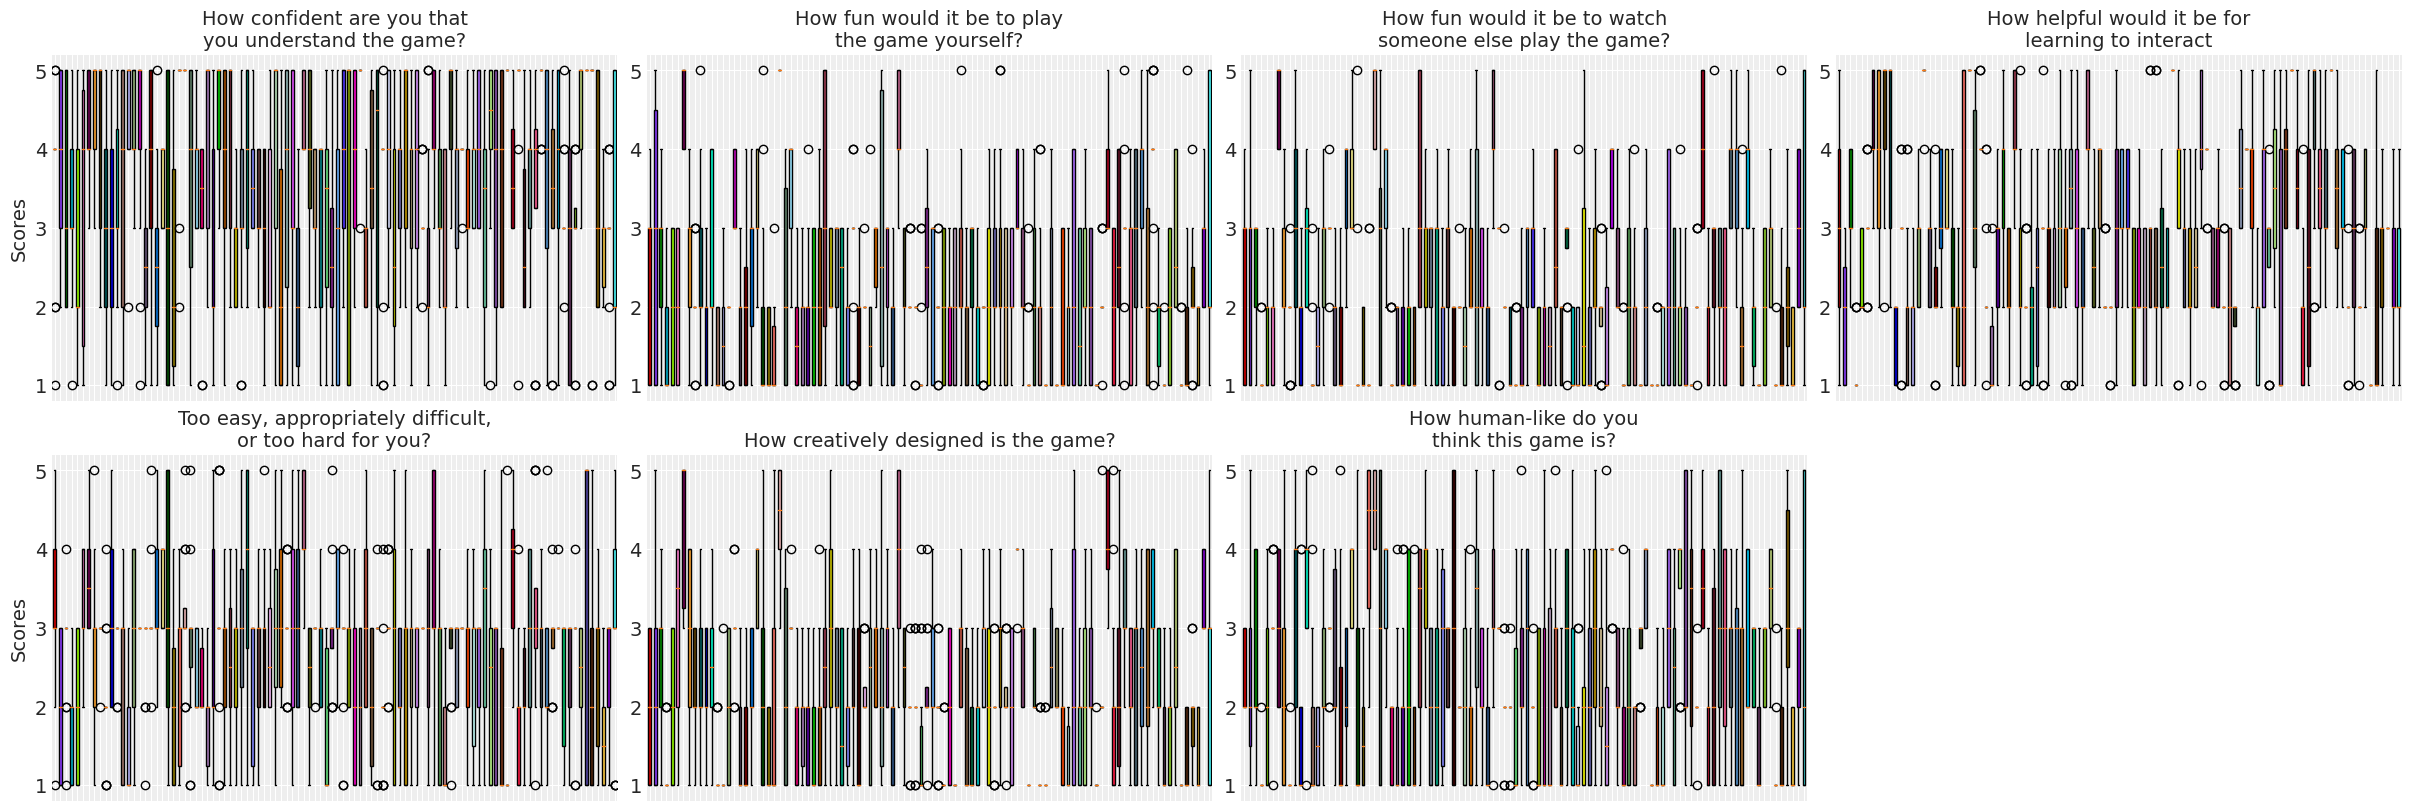

In [7]:
PANEL_HEIGHT = 4
PANEL_WIDTH = 6
NROWS = 2
NCOLS = 4
START_XLABELS_INDEX = 7
FONTDICT = dict(fontsize=14)

fig, axes = plt.subplots(NROWS, NCOLS, figsize=(PANEL_WIDTH * NCOLS, PANEL_HEIGHT * NROWS))
plt.subplots_adjust(hspace=0.2, wspace=0.2)
cmap = cc.cm.glasbey

grouped = current_participants_df.groupby('participant_id')
unique_values = list(current_participants_df.participant_id.unique())
data_by_participant_id = {pid: {} for pid in unique_values}

for i, (name, group) in enumerate(grouped):
    for attribute in NUMBER_SCORE_ATTRIBUTES:
        data_by_participant_id[name][attribute] = group[attribute].values


for i, (attribute, ax) in enumerate(zip(NUMBER_SCORE_ATTRIBUTES, chain.from_iterable(axes))):
    data = [data_by_participant_id[pid][attribute] for pid in unique_values]
    positions = np.arange(len(data))
    bp = ax.boxplot(data, positions=positions, patch_artist=True)

    # Loop over each boxplot and set the color
    for b, box in enumerate(bp['boxes']):
        box.set_facecolor(cmap(b))

    ax.set_xticklabels([''] * len(unique_values))
    if i % NCOLS == 0:
        ax.set_ylabel('Scores', fontdict=FONTDICT)

    ax.set_title(add_linebreaks(NUMBER_SCORE_AXIS_NAMES[attribute]), fontdict=FONTDICT)

    if i >= START_XLABELS_INDEX:
        ax.set_xticks(np.arange(len(unique_values)))
        ax.set_xticklabels(unique_values, rotation=90)
        ax.set_xlabel('Participant ID', fontdict=FONTDICT)

# clear the 8th axis
axes[-1][-1].axis('off')
plt.show()

## Per-game type bar plot on each questiion

/var/folders/h9/kzpqpksx6fq00v9d73x5j51c0000gn/T/ipykernel_4470/629242757.py:13: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.35, wspace=0.15)


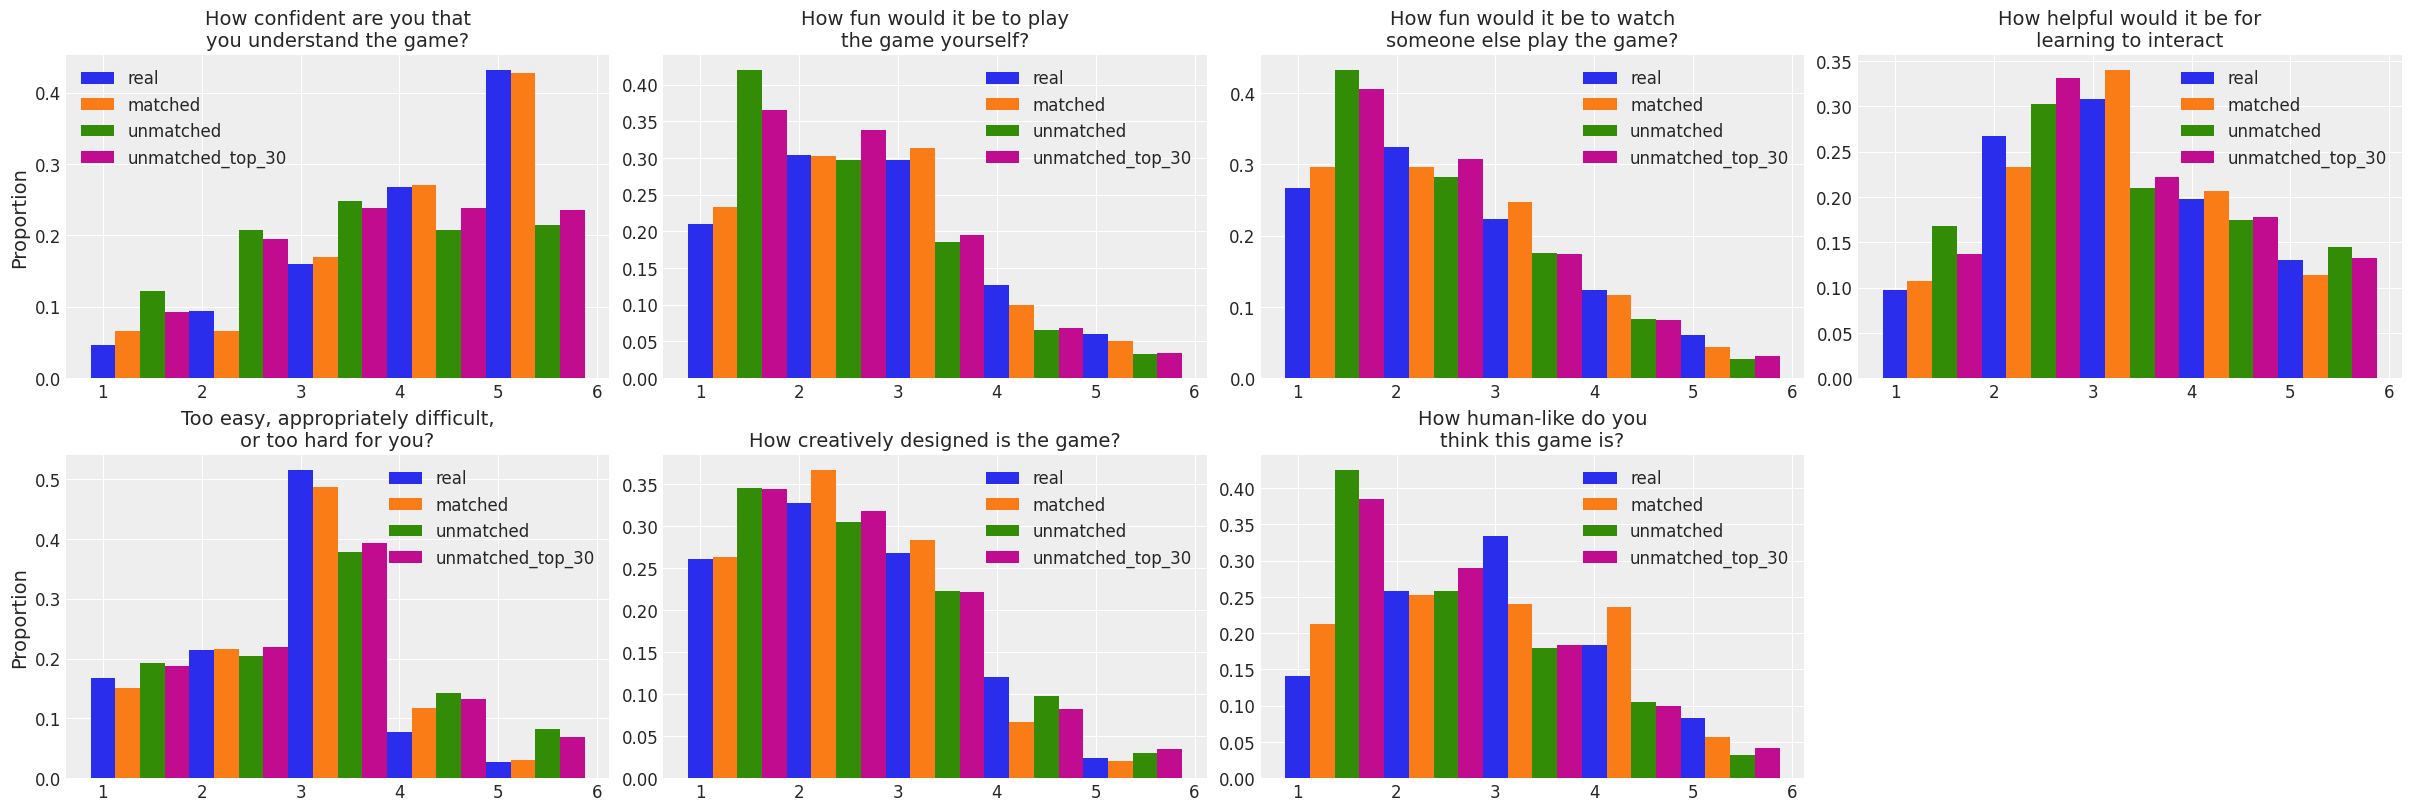

In [8]:
PANEL_HEIGHT = 4
PANEL_WIDTH = 6
NROWS = 2
NCOLS = 4
START_XLABELS_INDEX = 3
LEGEND_AX = 4
FONTDICT = dict(fontsize=14)
SEPARATE_PLOTS = False


if not SEPARATE_PLOTS:
    fig, axes = plt.subplots(NROWS, NCOLS, figsize=(PANEL_WIDTH * NCOLS, PANEL_HEIGHT * NROWS))
    plt.subplots_adjust(hspace=0.35, wspace=0.15)
    axes = list(chain.from_iterable(axes))

game_type_groupby = current_participants_df.groupby('game_type')
game_type_value_counts = current_participants_df.game_type.value_counts()

x = np.arange(5) + 1
width = 0.25
multiplier = 0

for i, attribute in enumerate(NUMBER_SCORE_ATTRIBUTES):
    if SEPARATE_PLOTS:
        fig, ax = plt.subplots(figsize=(PANEL_WIDTH, PANEL_HEIGHT))
    
    else:
        ax = axes[i]

    multiplier = 0
    for game_type in current_participants_df.game_type.cat.categories:
        offset = width * multiplier
        normalized_value_counts = game_type_groupby.get_group(game_type)[attribute].value_counts().sort_index() / game_type_value_counts[game_type]
        ax.bar(x + offset, normalized_value_counts, width=width, label=game_type)
        multiplier += 1

    ax.set_xlabel('')

    if i % NCOLS == 0:
        ax.set_ylabel('Proportion', fontdict=FONTDICT)

    # if i == LEGEND_AX:
    ax.legend(loc='best', fontsize=FONTDICT['fontsize'] - 2)

    ax.set_title(add_linebreaks(NUMBER_SCORE_AXIS_NAMES[attribute]), fontdict=FONTDICT)
    ax.tick_params(axis='both', which='major', labelsize=FONTDICT['fontsize'] - 2)

    if SEPARATE_PLOTS:
        plt.show()

if not SEPARATE_PLOTS:
    # clear the 8th axis
    axes[-1].axis('off')
    plt.show()


## Matched game difference comparison

/var/folders/h9/kzpqpksx6fq00v9d73x5j51c0000gn/T/ipykernel_4470/3563636189.py:10: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.5, wspace=0.15)


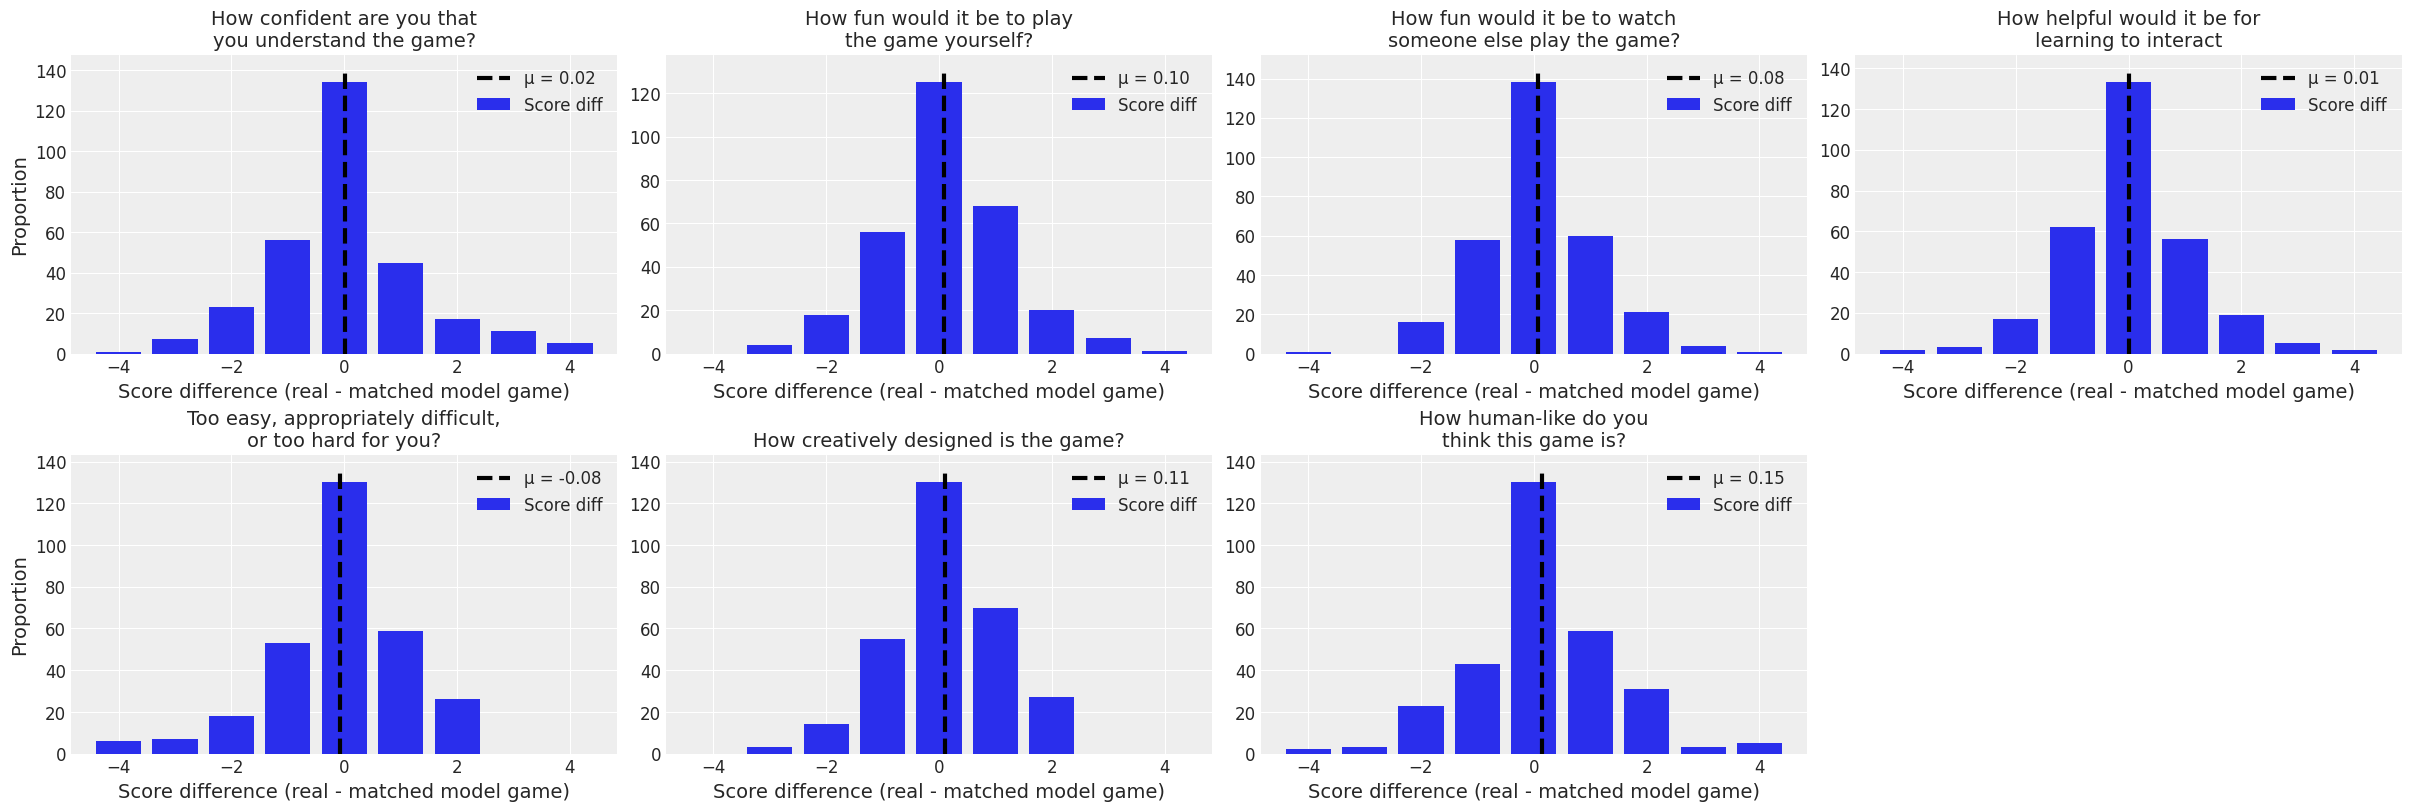

In [9]:
PANEL_HEIGHT = 4
PANEL_WIDTH = 6
NROWS = 2
NCOLS = 4
START_XLABELS_INDEX = 3
LEGEND_AX = 4
FONTDICT = dict(fontsize=14)

fig, axes = plt.subplots(NROWS, NCOLS, figsize=(PANEL_WIDTH * NCOLS, PANEL_HEIGHT * NROWS))
plt.subplots_adjust(hspace=0.5, wspace=0.15)

real_matched_df = current_participants_df[current_participants_df.game_type == 'real'].merge(
    current_participants_df[current_participants_df.game_type == 'matched'],
    on=['participant_id', 'game_id'],
    suffixes=('_real', '_matched')
)

x_values = np.arange(-4, 5)

for i, (attribute, ax) in enumerate(zip(NUMBER_SCORE_ATTRIBUTES, chain.from_iterable(axes))):
    attribute_diffs = real_matched_df[f'{attribute}_real'] - real_matched_df[f'{attribute}_matched']
    attribute_diff_counts = attribute_diffs.value_counts()
    ax.bar(x_values, [attribute_diff_counts.get(x, 0) for x in x_values], label='Score diff')
    ax.vlines(attribute_diffs.mean(), 0, ax.get_ylim()[1], color='black', label=f'\u03bc = {attribute_diffs.mean():.2f}', ls='--', lw=3)

    ax.set_xlabel('Score difference (real - matched model game)', fontdict=FONTDICT)

    if i % NCOLS == 0:
        ax.set_ylabel('Proportion', fontdict=FONTDICT)

    # if i == LEGEND_AX:
    ax.legend(loc='best', fontsize=FONTDICT['fontsize'] - 2)
    ax.set_title(add_linebreaks(NUMBER_SCORE_AXIS_NAMES[attribute]), fontdict=FONTDICT)
    ax.tick_params(axis='both', which='major', labelsize=FONTDICT['fontsize'] - 2)


# clear the 8th axis
axes[-1][-1].axis('off')
plt.show()



In [73]:
s = current_participants_df[current_participants_df.game_type == 'real'].groupby('full_game_id')[NUMBER_SCORE_ATTRIBUTES + ['num_preferences', 'node_count']].mean()
rho = s.corr()
pval = s.corr(method=lambda x, y: stats.pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho.round(2).astype(str) + p

,confident,fun_play,fun_watch,capability,goldilocks,creativity,human_likeness,num_preferences,node_count
confident,1.0***,0.34,0.11,-0.19,-0.46**,-0.43*,0.58***,-0.52**,-0.58***
fun_play,0.34,1.0***,0.88***,0.56**,0.41*,0.55**,0.77***,0.03,0.1
fun_watch,0.11,0.88***,1.0***,0.64***,0.49**,0.72***,0.68***,0.03,0.17
capability,-0.19,0.56**,0.64***,1.0***,0.41*,0.7***,0.21,0.41*,0.35
goldilocks,-0.46**,0.41*,0.49**,0.41*,1.0***,0.74***,0.09,0.4*,0.58***
creativity,-0.43*,0.55**,0.72***,0.7***,0.74***,1.0***,0.26,0.43*,0.6***
human_likeness,0.58***,0.77***,0.68***,0.21,0.09,0.26,1.0***,-0.18,-0.12
num_preferences,-0.52**,0.03,0.03,0.41*,0.4*,0.43*,-0.18,1.0***,0.8***
node_count,-0.58***,0.1,0.17,0.35,0.58***,0.6***,-0.12,0.8***,1.0***


In [83]:
s = current_participants_df[current_participants_df.game_type != 'unmatched'].groupby('full_game_id')[NUMBER_SCORE_ATTRIBUTES + ['num_preferences', 'node_count']].mean()
s = s.rename(columns={
    'confident': 'Understandable', 
    'fun_play': 'Fun to play', 
    'fun_watch': 'Fun to watch', 
    'capability': 'Helpful', 
    'goldilocks': 'Difficult', 
    'creativity': 'Creative',
    'human_likeness': 'Human-like',
    'num_preferences': 'Preferences',
    'node_count': 'Length',
})
rho = s.corr(method='spearman')
pval = s.corr(method=lambda x, y: stats.spearmanr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho_with_sig = rho.round(3).astype(str) + p
rho_smaller = rho_with_sig.iloc[:-2, -2:]
print(rho_smaller.style.to_latex())

\begin{tabular}{lll}
 & Preferences & Length \\
Understandable & -0.406*** & -0.279** \\
Fun to play & -0.084 & 0.15 \\
Fun to watch & -0.08 & 0.126 \\
Helpful & 0.216* & 0.214* \\
Difficult & 0.336** & 0.431*** \\
Creative & 0.357*** & 0.474*** \\
Human-like & -0.254* & 0.005 \\
\end{tabular}



In [71]:
s = current_participants_df[current_participants_df.game_type != 'unmatched'].groupby('full_game_id')[NUMBER_SCORE_ATTRIBUTES + ['num_preferences', 'node_count']].mean()
s = s.rename(columns={
    'confident': 'Understandable', 
    'fun_play': 'Fun to play', 
    'fun_watch': 'Fun to watch', 
    'capability': 'Helpful', 
    'goldilocks': 'Difficult', 
    'creativity': 'Creative',
    'human_likeness': 'Human-like',
    'num_preferences': 'Preferences',
    'node_count': 'Length',
})
corr_df = s.corr()
# corr_df = corr_df
corr_df = corr_df.style.format("{:.3f}").format_index("\\textit{{{}}}")
corr_df
# print(corr_df.to_latex())


,Understandable,Fun to play,Fun to watch,Helpful,Difficult,Creative,Human-like,Preferences,Length
\textit{Understandable},1.000,0.437,0.330,-0.130,-0.409,-0.322,0.596,-0.400,-0.290
\textit{Fun to play},0.437,1.000,0.876,0.444,0.223,0.463,0.782,-0.091,0.172
\textit{Fun to watch},0.330,0.876,1.000,0.504,0.263,0.566,0.711,-0.115,0.168
\textit{Helpful},-0.130,0.444,0.504,1.000,0.245,0.579,0.317,0.249,0.266
\textit{Difficult},-0.409,0.223,0.263,0.245,1.000,0.661,-0.024,0.348,0.430
\textit{Creative},-0.322,0.463,0.566,0.579,0.661,1.000,0.224,0.313,0.512
\textit{Human-like},0.596,0.782,0.711,0.317,-0.024,0.224,1.000,-0.258,0.008
\textit{Preferences},-0.400,-0.091,-0.115,0.249,0.348,0.313,-0.258,1.000,0.732
\textit{Length},-0.290,0.172,0.168,0.266,0.430,0.512,0.008,0.732,1.000


In [69]:
t = current_participants_df[current_participants_df.game_type != 'unmatched'][NUMBER_SCORE_ATTRIBUTES + ['num_preferences', 'node_count']]
t = t.rename(columns={
    'confident': 'Understandable', 
    'fun_play': 'Fun to play', 
    'fun_watch': 'Fun to watch', 
    'capability': 'Helpful', 
    'goldilocks': 'Difficult', 
    'creativity': 'Creative',
    'human_likeness': 'Human-like',
    'num_preferences': 'Preferences',
    'node_count': 'Length',
})
corr_df = t.corr()
corr_df = corr_df.style.format("{:.3f}").format_index("\\textit{{{}}}")  
print(corr_df.to_latex())

,Understandable,Fun to play,Fun to watch,Helpful,Difficult,Creative,Human-like,Preferences,Length
\textit{Understandable},1.000,0.295,0.134,0.069,-0.222,-0.065,0.340,-0.259,-0.181
\textit{Fun to play},0.295,1.000,0.804,0.419,0.257,0.551,0.627,-0.076,0.033
\textit{Fun to watch},0.134,0.804,1.000,0.389,0.322,0.562,0.503,-0.043,0.065
\textit{Helpful},0.069,0.419,0.389,1.000,0.221,0.436,0.271,0.094,0.047
\textit{Difficult},-0.222,0.257,0.322,0.221,1.000,0.427,0.086,0.203,0.185
\textit{Creative},-0.065,0.551,0.562,0.436,0.427,1.000,0.407,0.165,0.228
\textit{Human-like},0.340,0.627,0.503,0.271,0.086,0.407,1.000,-0.124,-0.002
\textit{Preferences},-0.259,-0.076,-0.043,0.094,0.203,0.165,-0.124,1.000,0.580
\textit{Length},-0.181,0.033,0.065,0.047,0.185,0.228,-0.002,0.580,1.000


## Run some matched-pairs t-tests

In [10]:
real_matched_df = current_participants_df[current_participants_df.game_type == 'real'].merge(
    current_participants_df[current_participants_df.game_type == 'matched'],
    on=['participant_id', 'game_id'],
    suffixes=('_real', '_matched')
)


for attribute in NUMBER_SCORE_ATTRIBUTES:
    result = stats.ttest_rel(real_matched_df[f'{attribute}_real'], real_matched_df[f'{attribute}_matched'])
    stars = '*' * int(result.pvalue < 0.05) + '*' * int(result.pvalue < 0.01) + '*' * int(result.pvalue < 0.001)
    print(f'{attribute}:') 
    print(f'\tt-statistic = {result.statistic}')
    print(f'\tp-value = {result.pvalue} {stars}')
    print()
    

confident:
	t-statistic = 0.21912596869609785
	p-value = 0.8267019285639725 

fun_play:
	t-statistic = 1.4694333064130782
	p-value = 0.14277019816909908 

fun_watch:
	t-statistic = 1.3148209591031503
	p-value = 0.1895810103987055 

capability:
	t-statistic = 0.20017977229676368
	p-value = 0.8414765256381358 

goldilocks:
	t-statistic = -1.0881976628447936
	p-value = 0.2773871540706674 

creativity:
	t-statistic = 1.8069461997523575
	p-value = 0.07177917977652712 

human_likeness:
	t-statistic = 2.010143767520546
	p-value = 0.045316874710284116 *



## A table of unmatched t-tests between the unmatched games and other ones

In [11]:
rows = []
UNMATCHED_TOP_30 = 'unmatched_top_30'
REAL = 'real'
MATCHED = 'matched'
AST = '*'
USE_NORMALIZED = False
RESULT_COLUMN_TEXT_SIZE = 'footnotesize'

# category_order_for_t_tests = [UNMATCHED_TOP_30, REAL, MATCHED]
category_order_for_means = [REAL, MATCHED, UNMATCHED_TOP_30]

for attribute in NUMBER_SCORE_ATTRIBUTES:
    if USE_NORMALIZED:
        attribute = f'normalized_{attribute}'

    attribute_name = NUMBER_SCORE_AXIS_NAMES[attribute]
    # attribute_name = attribute.replace('_', '\\_').replace('alized', '')

    row = [attribute_name] + [current_participants_df[current_participants_df.game_type == category][attribute].mean() for category in category_order_for_means]
    for first, second in combinations(category_order_for_means, 2):
        first_data = current_participants_df[current_participants_df.game_type == first][attribute]
        second_data = current_participants_df[current_participants_df.game_type == second][attribute]
        # result = stats.ttest_ind(first_data, second_data)
        result = stats.mannwhitneyu(first_data, second_data)
        statistic, p_value = result.statistic, result.pvalue
        stars = AST * int(p_value < 0.05) + AST * int(p_value < 0.01) + AST * int(p_value < 0.001)
        if stars:
            # stars = f'\\textsuperscript{{ \\textbf {{ {stars} }} }}'
            stars = f'^{{ {stars} }}'
        # else:
        #     stars = '$'
            
        if p_value < 1e-5:
            p_value = r'$P < \num{1e-5}' + stars + '$'

        elif p_value < 1e-3:
            p_value = r'$P < \num{1e-3}' + stars + '$'

        else:
            p_value = f'$P = {p_value:.3f}{stars}$'

        # row.extend([f'{{ \\{RESULT_COLUMN_TEXT_SIZE} {statistic:.1f} }}', f'{{ \\{RESULT_COLUMN_TEXT_SIZE} {p_value} }}'])
        row.extend([f'{{ \\{RESULT_COLUMN_TEXT_SIZE} {statistic:.1f} }}, {{ \\{RESULT_COLUMN_TEXT_SIZE} {p_value} }}'])

    rows.append(row)


HEADERS = [
    'Attribute', 'Real', 'Matched', 'Unmatched',
    'U-stat, p-value', 'U-stat, p-value', 'U-stat, p-value'
]

tabulated = tabulate(rows, headers=HEADERS, floatfmt='.3f', tablefmt='latex_raw')
print(tabulated)
    

\begin{tabular}{lrrrlll}
\hline
 Attribute                                                &   Real &   Matched &   Unmatched & U-stat, p-value                                          & U-stat, p-value                                                       & U-stat, p-value                                                       \\
\hline
 How confident are you that you understand the game?      &  3.943 &     3.923 &       3.331 & { \footnotesize 45088.0 }, { \footnotesize $P = 0.906$ } & { \footnotesize 55921.5 }, { \footnotesize $P < \num{1e-5}^{ *** }$ } & { \footnotesize 55846.0 }, { \footnotesize $P < \num{1e-5}^{ *** }$ } \\
 How fun would it be to play the game yourself?           &  2.522 &     2.430 &       2.068 & { \footnotesize 46752.5 }, { \footnotesize $P = 0.352$ } & { \footnotesize 54040.5 }, { \footnotesize $P < \num{1e-5}^{ *** }$ } & { \footnotesize 52539.5 }, { \footnotesize $P < \num{1e-3}^{ *** }$ } \\
 How fun would it be to watch someone else play the game? &  2.3

## Trying to compute some inter-annotator agreement data

In [12]:
tab = '    '

for attribute in NUMBER_SCORE_ATTRIBUTES:
    print(f'{attribute}:') 
    pivot_table = pd.pivot_table(current_participants_df, values=attribute, index='participant_id', columns='full_game_id')
    alpha = krippendorff.alpha(pivot_table.values, level_of_measurement='ordinal')
    print(f'{tab}\u03b1 = {alpha:.3f}')
    pivot_table_real_matched_only = pd.pivot_table(current_participants_df[current_participants_df.game_type != 'unmatched'], values=attribute, index='participant_id', columns='full_game_id')
    alpha = krippendorff.alpha(pivot_table_real_matched_only.values, level_of_measurement='ordinal')
    print(f'{tab}\u03b1 (real and matched only) = {alpha:.3f}')

    print()




confident:
    α = 0.228
    α (real and matched only) = 0.233

fun_play:
    α = 0.123
    α (real and matched only) = 0.117

fun_watch:
    α = 0.088
    α (real and matched only) = 0.077

capability:
    α = 0.016
    α (real and matched only) = 0.023

goldilocks:
    α = 0.202
    α (real and matched only) = 0.211

creativity:
    α = 0.115
    α (real and matched only) = 0.129

human_likeness:
    α = 0.150
    α (real and matched only) = 0.151



## Histogram of the values per question

/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 37.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 37.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 23.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


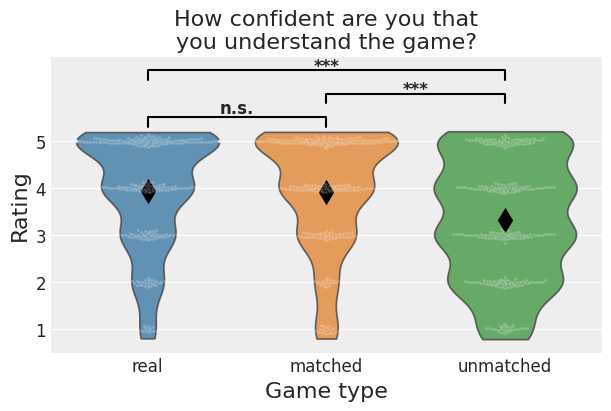

/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 32.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 36.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 39.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


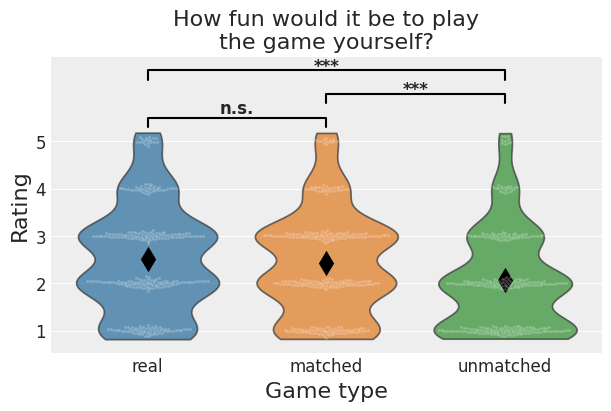

/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 32.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 35.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 38.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


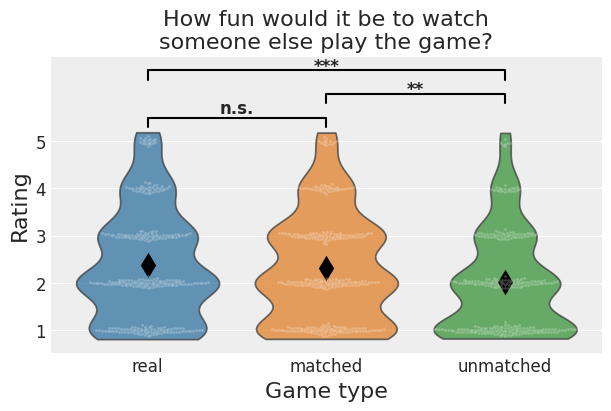

/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 28.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 29.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 22.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


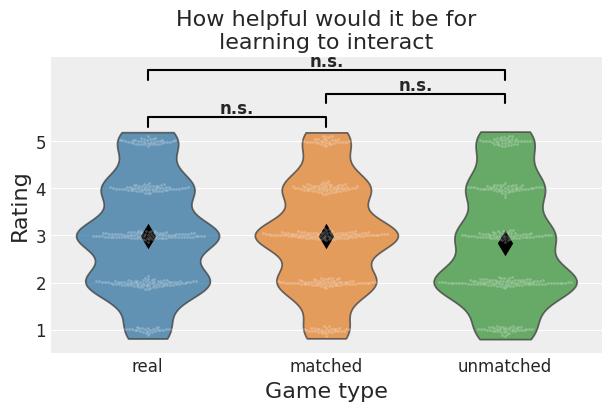

/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 40.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 37.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 29.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 7.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warni

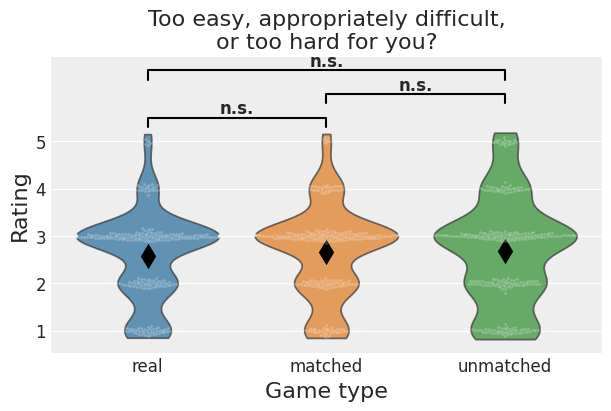

/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 36.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 42.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 38.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


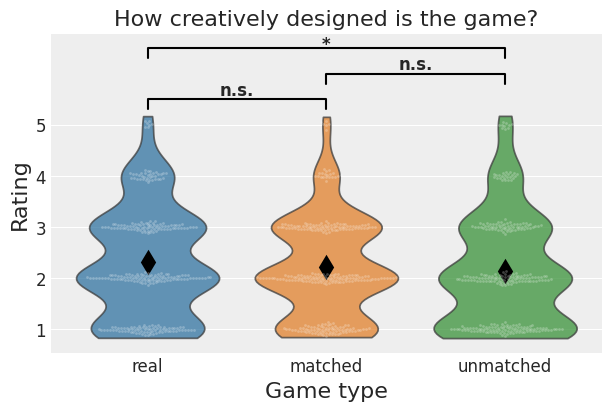

/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 28.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 29.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 35.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


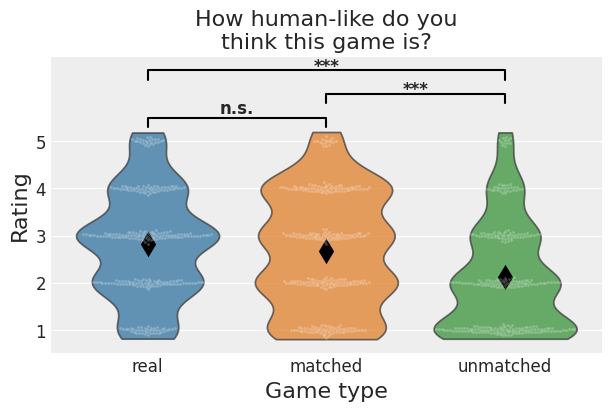

In [55]:
PANEL_HEIGHT = 4
PANEL_WIDTH = 6
NROWS = 2
NCOLS = 4
START_XLABELS_INDEX = 3
LEGEND_AX = 4
FONTDICT = dict(fontsize=16)
SEPARATE_PLOTS = True
N_BINS = 20
USE_NORMALIZED = False
ANNOTATION_INCREMENT = 0.5
PAIRS = [('real', 'matched'), ('matched', 'unmatched'), ('real', 'unmatched')]

if not SEPARATE_PLOTS:
    fig, axes = plt.subplots(NROWS, NCOLS, figsize=(PANEL_WIDTH * NCOLS, PANEL_HEIGHT * NROWS))
    plt.subplots_adjust(hspace=0.35, wspace=0.15)
    axes = list(chain.from_iterable(axes))



ANNOTATION_LINEPLOT_KWARGS = dict(lw=1.5, c='black')
ANNOTATION_TEXT_KWARGS = dict(fontsize=12, ha='center', va='bottom', weight='bold')


def annotate_significance(ax: plt.Axes, attribute: str, pair: typing.Tuple[str, str], data_df: pd.DataFrame, 
                          y_increment: float = 0, y_margin: float = 0.2, bar_y: float = 0.2, 
                          AST: str = '*', starts_only_y_dec: float = 0.1,
                          plot_kwargs: dict = ANNOTATION_LINEPLOT_KWARGS,
                          text_kwargs: dict = ANNOTATION_TEXT_KWARGS):
    category_to_position = {t.get_text(): t._x for t in ax.get_xticklabels() if t.get_text() in pair}

    first_data = data_df[data_df.game_type == pair[0]][attribute]
    second_data = data_df[data_df.game_type == pair[1]][attribute]
    # result = stats.ttest_ind(first_data, second_data)
    result = stats.mannwhitneyu(first_data, second_data)
    p_value = result.pvalue
    stars = AST * int(p_value < 0.05) + AST * int(p_value < 0.01) + AST * int(p_value < 0.001)
    if not stars:
        stars = 'n.s.'

    y_max = max(first_data.max(), second_data.max())
    y_bar_start = y_max + y_margin + y_increment
    y_bar_end = y_bar_start + bar_y

    points = [
        (category_to_position[pair[0]], y_bar_start),
        (category_to_position[pair[0]], y_bar_end),
        (category_to_position[pair[1]], y_bar_end),
        (category_to_position[pair[1]], y_bar_start),
    ]
    x, y = zip(*points)

    ax.plot(list(x), list(y), **plot_kwargs)

    middle = (category_to_position[pair[0]] + category_to_position[pair[1]]) / 2
    text_height = y_bar_end - starts_only_y_dec if '*' in stars else y_bar_end
    ax.text(middle, text_height, stars, **text_kwargs)


no_full_unmatched_df = current_participants_df[current_participants_df.game_type != 'unmatched'].copy(deep=True)
no_full_unmatched_df.game_type = no_full_unmatched_df.game_type.cat.remove_unused_categories()
no_full_unmatched_df.game_type = no_full_unmatched_df.game_type.cat.rename_categories({'unmatched_top_30': 'unmatched'})


for i, attribute in enumerate(NUMBER_SCORE_ATTRIBUTES):
    if SEPARATE_PLOTS:
        fig, ax = plt.subplots(figsize=(PANEL_WIDTH, PANEL_HEIGHT))
    
    else:
        ax = axes[i]

    if USE_NORMALIZED:
        attribute = f'normalized_{attribute}'

    # histotgram_data = [current_participants_df[current_participants_df.game_type == game_type][attribute] for game_type in current_participants_df.game_type.cat.categories]
    # ax.hist(histotgram_data, bins=N_BINS, label=current_participants_df.game_type.cat.categories, alpha=0.75, density=True)
    
    # bodies = ax.violinplot(histotgram_data, showmeans=True, showextrema=True, vert=True, widths=0.7)
    # legend_entries = []
    # for i, pc in enumerate(bodies['bodies']):
    #     pc.set_facecolor(cm.tab10(i))
    #     legend_entries.append(mpatches.Patch(facecolor=pc.get_facecolor(), label=current_participants_df.game_type.cat.categories[i]))

    sns.violinplot(data=no_full_unmatched_df, x='game_type', y=attribute, ax=ax, hue='game_type', palette='tab10', inner=None, alpha=0.75, cut=0.5)
    ax = sns.swarmplot(data=no_full_unmatched_df, x='game_type', y=attribute, ax=ax, color='white', dodge=True, size=2, alpha=0.25)
    for dots in ax.collections:
        offsets = dots.get_offsets()
        if offsets.shape[0] > 10:
            jittered_offsets = np.copy(offsets)
            jittered_offsets[:, 1] = jittered_offsets[:, 1] + np.random.normal(0, 0.05, size=jittered_offsets.shape[0])
            dots.set_offsets(jittered_offsets)
    
    # draw means and confidence intervals around them
    # means = current_participants_normalized_df.groupby('game_type')[attribute].mean()
    # stds = current_participants_normalized_df.groupby('game_type')[attribute].std()
    # for i, game_type in enumerate(current_participants_df.game_type.cat.categories):
    #     ax.errorbar(i, means[game_type], yerr=1.96 * stds[game_type] / np.sqrt(len(histotgram_data[i])), fmt='-', color='black', 
    #                 elinewidth=2, capthick=2, capsize=15, barsabove=True)

    sns.pointplot(data=no_full_unmatched_df, x='game_type', y=attribute, ax=ax, errorbar=('ci', 95), linestyle='none', color='black', markers='d',
                  markersize=10)
    
    ax.set_xlabel('Game type', fontdict=FONTDICT)

    # if i % NCOLS == 0:
    ax.set_ylabel('Rating', fontdict=FONTDICT)

    ax.set_yticks(np.arange(1, 6))

    ax.set_title(add_linebreaks(NUMBER_SCORE_AXIS_NAMES[attribute]), fontdict=FONTDICT)
    ax.tick_params(axis='both', which='major', labelsize=FONTDICT['fontsize'] - 4)

    for i, pair in enumerate(PAIRS):
        annotate_significance(ax, attribute, pair, no_full_unmatched_df, y_increment=i * ANNOTATION_INCREMENT + 0.1)    

    if SEPARATE_PLOTS:
        plt.show()


if not SEPARATE_PLOTS:
    # clear the 8th axis
    axes[-1].axis('off')
    plt.show()


In [38]:
category_to_position = {t.get_text(): t._x for t in ax.get_xticklabels()}

category_to_position



In [ ]:
tab = '    '

for attribute in NUMBER_SCORE_ATTRIBUTES:
    print(f'{attribute}:') 
    for first, second in combinations(current_participants_df.game_type.cat.categories, 2):
        first_data = current_participants_df[current_participants_df.game_type == first][f'normalized_{attribute}']
        second_data = current_participants_df[current_participants_df.game_type == second][f'normalized_{attribute}']
        result = stats.ttest_ind(first_data, second_data)
        stars = '*' * int(result.pvalue < 0.05) + '*' * int(result.pvalue < 0.01) + '*' * int(result.pvalue < 0.001)
        print(f'{first} (\u03bc = {first_data.mean():.2f}) vs {second} (\u03bc = {second_data.mean():.2f})')
        p = result.pvalue
        p_value_str = f'p-value < 1e-7 {stars}' if p < 1e-7 else (f'p-value < 1e-5 {stars}' if p < 1e-5 else f'p-value = {p:.4f} {stars}')
        print(f'{tab}t-statistic = {result.statistic:.3f}, {p_value_str}')
        print()
        # print(f'{tab}p-value    = {result.pvalue:.3e} {stars}')

    print()

    

In [ ]:
PANEL_HEIGHT = 4
PANEL_WIDTH = 6
NROWS = 2
NCOLS = 4
START_XLABELS_INDEX = 3
LEGEND_AX = 4
FONTDICT = dict(fontsize=14)
N_BINS = 20

fig, axes = plt.subplots(NROWS, NCOLS, figsize=(PANEL_WIDTH * NCOLS, PANEL_HEIGHT * NROWS))
plt.subplots_adjust(hspace=0.5, wspace=0.15)

real_matched_df = current_participants_df[current_participants_df.game_type == 'real'].merge(
    current_participants_df[current_participants_df.game_type == 'matched'],
    on=['participant_id', 'game_id'],
    suffixes=('_real', '_matched')
)

x_values = np.arange(-4, 5)

for i, (attribute, ax) in enumerate(zip(NUMBER_SCORE_ATTRIBUTES, chain.from_iterable(axes))):
    attribute_diffs = real_matched_df[f'normalized_{attribute}_real'] - real_matched_df[f'normalized_{attribute}_matched']
    # attribute_diff_counts = attribute_diffs.value_counts()
    ax.hist(attribute_diffs, bins=N_BINS, density=True, label='Score diff')
    ax.vlines(attribute_diffs.mean(), 0, ax.get_ylim()[1], color='black', label=f'\u03bc = {attribute_diffs.mean():.2f}', ls='--', lw=3)

    ax.set_xlabel('Score difference (real - matched model game)', fontdict=FONTDICT)

    if i % NCOLS == 0:
        ax.set_ylabel('Proportion', fontdict=FONTDICT)

    # if i == LEGEND_AX:
    ax.legend(loc='best', fontsize=FONTDICT['fontsize'] - 2)
    ax.set_title(add_linebreaks(NUMBER_SCORE_AXIS_NAMES[attribute]), fontdict=FONTDICT)
    ax.tick_params(axis='both', which='major', labelsize=FONTDICT['fontsize'] - 2)


# clear the 8th axis
axes[-1][-1].axis('off')
plt.show()



In [ ]:
real_matched_df = current_participants_df[current_participants_df.game_type == 'real'].merge(
    current_participants_df[current_participants_df.game_type == 'matched'],
    on=['participant_id', 'game_id'],
    suffixes=('_real', '_matched')
)


for attribute in NUMBER_SCORE_ATTRIBUTES:
    result = stats.ttest_rel(real_matched_df[f'{attribute}_real'], real_matched_df[f'{attribute}_matched'])
    stars = '*' * int(result.pvalue < 0.05) + '*' * int(result.pvalue < 0.01) + '*' * int(result.pvalue < 0.001)
    print(f'{attribute}:') 
    print(f'\tt-statistic = {result.statistic}')
    print(f'\tp-value = {result.pvalue} {stars}')
    print()
    

# Trying to run some mixed effects models

In [ ]:
current_participants_df = current_participants_df.assign(
    game_type_real=pd.Series(current_participants_df.game_type == 'real', dtype=int),
    game_type_matched=pd.Series(current_participants_df.game_type == 'matched', dtype=int),
    game_type_unmatched=pd.Series(current_participants_df.game_type == 'unmatched', dtype=int),
    game_type_unmatched_top_30=pd.Series(current_participants_df.game_type == 'unmatched_top_30', dtype=int),
    game_type=current_participants_df.game_type.cat.reorder_categories(['unmatched', 'unmatched_top_30', 'matched', 'real']),
)

current_participants_no_full_unmatched_df = current_participants_df[current_participants_df.game_type != 'unmatched']
current_participants_no_full_unmatched_df = current_participants_no_full_unmatched_df.assign(
    game_type=current_participants_no_full_unmatched_df.game_type.cat.remove_unused_categories(),  # .cat.reorder_categories(['real', 'matched', 'unmatched_top_30'])
    full_game_id=current_participants_no_full_unmatched_df.full_game_id.cat.remove_unused_categories(),
    # normalized_fitness=(current_participants_no_full_unmatched_df.fitness - current_participants_no_full_unmatched_df.fitness.mean()) / (current_participants_no_full_unmatched_df.fitness.std()),
    # normalized_fitness=(current_participants_normalized_no_full_unmatched_df.fitness - current_participants_normalized_no_full_unmatched_df.fitness.min()) / (current_participants_normalized_no_full_unmatched_df.fitness.max()),
)
current_participants_no_full_unmatched_df = current_participants_no_full_unmatched_df.reset_index()

print(current_participants_no_full_unmatched_df.shape, current_participants_no_full_unmatched_df.index.max())
current_participants_no_full_unmatched_df.head()

In [ ]:
# vc = {'participant_id': '0 + C(participant_id)'}
# md = smf.mixedlm('confident ~ game_type', current_participants_normalized_df, groups='game_type', vc_formula=vc)
# mdf = md.fit()

candidate_models = {
    # 'no_fitness': '1 + game_type',
    'fitness': '1 + game_type + normalized_fitness',
    # 'fitness_by_type': '1 + game_type + normalized_fitness + game_type:normalized_fitness',
}


'confident ~ 1 + game_type'

# vc = {'full_game_id': '0 + C(full_game_id)'}
vc = {'participant_id': '0 + C(participant_id)', 'full_game_id': '0 + C(full_game_id)'}
for attribute in NUMBER_SCORE_ATTRIBUTES:
    display(Markdown(f'### {attribute}:'))
    best_mdf = None
    best_llf = float('-inf')
    for model_name, model_formula in candidate_models.items():
        md = smf.mixedlm(f'normalized_{attribute} ~ {model_formula}', current_participants_no_full_unmatched_df, groups='game_type', vc_formula=vc)
        mdf = md.fit()
        print(f'{model_name}: {mdf.llf:3f}')
        if mdf.llf > best_llf:
            best_llf = mdf.llf
            best_mdf = mdf


    # md = smf.mixedlm(f'{attribute} ~ game_type + 1 + normalized_fitness', current_participants_normalized_no_full_unmatched_df, groups='participant_id', vc_formula=vc)
    # md = smf.mixedlm(f'{attribute} ~ game_type + 1 + (fitness * game_type)', current_participants_normalized_no_full_unmatched_df, groups='participant_id', vc_formula=vc)
    # mdf = md.fit()
    display(best_mdf.summary())
    display(Markdown('-----------'))
    





In [ ]:
# debrief_key = 'comments'
debrief_key = 'strategy'
# debrief_key = 'aids'
# debrief_key = 'techDifficulties'

min_length = 10

for participant_data in current_participants_raw_data:
    debrief_responses = participant_data.data.debrief_responses
    if debrief_key in debrief_responses and len(debrief_responses[debrief_key]) > min_length:
        print(f'{debrief_responses[debrief_key]}')



## Messing around with Stan

### TODOs:
* Set up all models to accept held-out data
* Set up all models to generate the generated quantities
* Set up a pipelien to run and evaluate all of the models
* ...
* Profit?

In [ ]:
stan_df = current_participants_df[current_participants_df.game_type != 'unmatched'].copy()
stan_df = stan_df.assign(
    game_type=stan_df.game_type.cat.remove_unused_categories().cat.reorder_categories(['unmatched_top_30', 'matched', 'real']),  
    full_game_id=stan_df.full_game_id.cat.remove_unused_categories(),
)
stan_df = stan_df.reset_index()

In [ ]:
DEFAULT_RANDOM_SEED = 33


def map_game_type_to_index(df: pd.DataFrame) -> np.ndarray:
    full_game_id_to_code = {category: code for code, category in enumerate(df.full_game_id.cat.categories)}
    game_type_to_code = {category: code + 1 for code, category in enumerate(df.game_type.cat.categories)}

    game_types_by_index = np.zeros(len(full_game_id_to_code), dtype=int)

    for _, row in df.iterrows():
        full_game_id_code = full_game_id_to_code[row.full_game_id]
        game_type_code = game_type_to_code[row.game_type]
        
        if game_types_by_index[full_game_id_code] != 0:
            if game_types_by_index[full_game_id_code] != game_type_code:
                print(f'Conflicting game types for {row.full_game_id}: {game_types_by_index[full_game_id_code]} and {game_type_code}')

        else:
            game_types_by_index[full_game_id_code] = game_type_code

    return game_types_by_index


def split_train_val_indices_by_category(df: pd.DataFrame, category: str = 'participant_id',
                                        val_per_category: int = 1, 
                                        random_seed: int = DEFAULT_RANDOM_SEED):
    unique_values = df[category].unique()
    train, val = train_test_split(df, test_size=len(unique_values) * val_per_category, 
                                   random_state=random_seed, stratify=df[category])

    return train.index.values, val.index.values


def split_data_by_indices(data: typing.Dict[str, typing.Any], train_indices: np.ndarray, val_indices: np.ndarray,
                          total_key: str = 'N', validation_suffix: str = '_val') -> typing.Dict[str, typing.Any]:
    total = data[total_key]
    current_keys = list(data.keys())

    for key in current_keys:
        current_value = data[key]
        if isinstance(current_value, np.ndarray) and len(current_value) == total:
            train_data = current_value[train_indices]
            val_data = current_value[val_indices]

            data[key] = train_data
            data[f'{key}{validation_suffix}'] = val_data

    data[total_key] = len(train_indices)
    data[f'{total_key}{validation_suffix}'] = len(val_indices)

    return data


def hash_file(file_path: str, buffer_size: int = 128*1024) -> str:
    h  = hashlib.sha256()
    b  = bytearray()
    mv = memoryview(b)

    with open(file_path, 'rb', buffering=0) as f:
        while n := f.readinto(mv):
            h.update(mv[:n])
    
    return h.hexdigest()


In [ ]:
# MODEL_DIR = './stan_models'
# MODEL_FILENAME_FORMAT = '{filename}'
MODEL_DIR = './stan_models/ordinal'
MODEL_FILENAME_FORMAT = 'ordinal_{filename}'

CANDIDATE_MODEL_TO_PATH = {
    'Game type and fitness': 'model_game_type_and_fitness.stan',
    '+ Participant effect': 'model_participant_effect.stan',
    '+ Hierarchical participant effect': 'model_participant_hierarchical.stan',
    '+ Hierarchical participant effect + stddev': 'model_participant_hierarchical_sigma.stan',
    '+ Hierarchical game effect by type': 'model_participant_effect_hierarchical_game.stan',
    '+ Hierarchical game effect by type + intercept': 'model_participant_effect_hierarchical_game_intercept.stan',
}

CANDIDATE_MODEL_TO_PATH = {
    name: os.path.join(MODEL_DIR, MODEL_FILENAME_FORMAT.format(filename=filename)) 
    for name, filename in CANDIDATE_MODEL_TO_PATH.items()}
CANDIDATE_MODELS = {} 
for name, path in CANDIDATE_MODEL_TO_PATH.items():
    print(name, path)
    CANDIDATE_MODELS[name] = CmdStanModel(stan_file=path)
CANDIDATE_MODEL_HASHES = {name: hash_file(model.exe_file) for name, model in CANDIDATE_MODELS.items()}

In [ ]:
ATTRIBUTE = 'fully_normalized_capability'
SHELVES_FOLDER = './stan_models/shelves'

MODEL_FITS_BY_ATTRIBUTE = os.path.abspath(os.path.join(SHELVES_FOLDER, 'model_fits.shelve'))
MODEL_FIT_HASHES_BY_ATTRIBUTE = os.path.abspath(os.path.join(SHELVES_FOLDER, 'model_fit_hashes.shelve'))
INFERENCE_DATA_BY_ATTRIBUTE = os.path.abspath(os.path.join(SHELVES_FOLDER, 'inference_data.shelve'))
COMPARISON_DATA_BY_ATTRIBUTE = os.path.abspath(os.path.join(SHELVES_FOLDER, 'comparison_data.shelve'))


def write_to_shelf(path: str, key: str, value: typing.Any, attribute: str = ATTRIBUTE):
    with shelve.open(path) as db:
        if attribute not in db:
            db[attribute] = {}

        db[attribute][key] = value


def read_from_shelf(path: str, key: str, attribute: str = ATTRIBUTE) -> typing.Any:
    with shelve.open(path) as db:
        if attribute not in db:
            return None

        return db[attribute].get(key)


df = stan_df

data = dict(
    N=df.shape[0],
    G=len(df.game_type.cat.categories), 
    P=len(df.participant_id.cat.categories),
    U=len(df.full_game_id.cat.categories),
    K=5,

    attr=df[ATTRIBUTE].values,
    attr_ordinal=df[ATTRIBUTE.replace('fully_normalized_', '')].values, 
    normalized_fitness=df.normalized_fitness.values,
    game_types=df.game_type.cat.codes.values + 1,  # type: ignore
    participants=df.participant_id.cat.codes.values + 1,  # type: ignore
    game_indices=df.full_game_id.cat.codes.values + 1,  # type: ignore
    game_types_by_index=map_game_type_to_index(df),
)

train_indices, val_indices = split_train_val_indices_by_category(df, category='full_game_id',
                                                                 val_per_category=1,
                                                                 random_seed=DEFAULT_RANDOM_SEED)
data = split_data_by_indices(data, train_indices, val_indices)

In [ ]:
DIAGNOSIS_PASS = 'Processing complete, no problems detected.'
SKIP_MODEL_NAMES = ['+ Hierarchical participant effect + stddev', '+ Hierarchical game effect by type']


with shelve.open(MODEL_FIT_HASHES_BY_ATTRIBUTE) as model_fits_db:
    with shelve.open(MODEL_FIT_HASHES_BY_ATTRIBUTE) as model_fits_hashes_db:

        for name, model in CANDIDATE_MODELS.items():
            if name in SKIP_MODEL_NAMES:
                print(f'Skipping {name} because it has been identified as problematic.')
                continue

            if name in model_fits_db and model_fits_hashes_db.get(name, None) == CANDIDATE_MODEL_HASHES[name]:
                print(f'Skipping {name} because it has already been fit.')
                continue

            display(Markdown(f'## {name}'))
            model_fit = model.sample(data=data, seed=DEFAULT_RANDOM_SEED)

            if ATTRIBUTE not in model_fits_db:
                model_fits_db[ATTRIBUTE] = {}

            print([k for k in model_fits_db.keys()])

            model_fits_db[ATTRIBUTE][name] = model_fit

            if ATTRIBUTE not in model_fits_hashes_db:
                model_fits_hashes_db[ATTRIBUTE] = {}

            model_fits_hashes_db[ATTRIBUTE][name] = CANDIDATE_MODEL_HASHES[name]

            diagnosis = model_fit.diagnose()
            if DIAGNOSIS_PASS not in diagnosis:  # type: ignore
                display(Markdown(f'### Diagnostics did not pass for {name}:'))
                print(diagnosis)

            display(Markdown('--------'))

            break

        model_fits_db.sync()
        model_fits_hashes_db.sync()


In [ ]:
with shelve.open(MODEL_FIT_HASHES_BY_ATTRIBUTE) as model_fits_hashes_db:
    with shelve.open(INFERENCE_DATA_BY_ATTRIBUTE) as inference_data_db:
        for name, model_fit in model_fits_hashes_db[ATTRIBUTE].items():
            ordinal_model = any(c.startswith('attr_ordinal') for c in model_fit.column_names)
            if ordinal_model:
                posterior_predictive = ['attr_ordinal_pred', 'attr_ordinal_val_pred']
                log_likelihood = {'attr_ordinal': 'log_lik', 'attr_ordinal_val': 'log_lik_val', 'attr_ordinal_pred': 'log_lik_pred', 'attr_ordinal_val_pred': 'log_lik_val_pred'}

            else:
                posterior_predictive = ['attr_pred', 'attr_val_pred']
                log_likelihood = {'attr': 'log_lik', 'attr_val': 'log_lik_val', 'attr_pred': 'log_lik_pred', 'attr_val_pred': 'log_lik_val_pred'}

            print(name)
            if ATTRIBUTE not in inference_data_db:
                inference_data_db[ATTRIBUTE] = {}

            inference_data_db[ATTRIBUTE][name] = az.from_cmdstanpy(
                posterior=model_fit,
                posterior_predictive=posterior_predictive,
                log_likelihood=log_likelihood,
                # log_likelihood={'attr': 'log_lik_pred', 'attr_val': 'log_lik_val_pred'},
                observed_data=data,
                coords={
                    'participant_id': df.participant_id.cat.categories, 
                    'game_type': df.game_type.cat.categories,
                    'full_game_id': df.full_game_id.cat.categories
                },
                # dims={'attr': ['participant_id', 'game_type']}
            )




In [ ]:
PLOT_PARAMETERS = ['alpha', 'beta_fitness', 'beta', 'game_type_mu', 'game_type_sigma', 'participant_effect_mean', 'participant_effect_sigma', 'sigma', 'sigma_mean', 'cutpoints']
HDI_PROB = 0.9


def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])


with shelve.open(INFERENCE_DATA_BY_ATTRIBUTE) as inference_data_db:
    for name, idata in inference_data_db[ATTRIBUTE].items():
        relevant_parameters = [param for param in PLOT_PARAMETERS if param in idata.posterior.data_vars]
        display(Markdown(f'## {name}'))
        hdi = az.hdi(idata, hdi_prob=HDI_PROB, var_names=relevant_parameters)
        display(hdi)
        # az.plot_posterior(idata, var_names=relevant_parameters)
        # plt.show()
        trace_axes = az.plot_trace(idata, var_names=relevant_parameters,)
        for i, rp in enumerate(relevant_parameters):
            values = hdi[rp].values
            if len(values.shape) == 1:
                values = np.expand_dims(values, axis=0)

            for j in range(values.shape[0]):
                vals = values[j, :]
                ax = trace_axes[i, 0]
                y_min, y_max = ax.get_ylim()
                y_diff = y_max - y_min
                height = (0.15 + 0.15 * j) * y_diff + y_min
                text_height = height + 0.05 * y_diff
                color = plt.rcParams['axes.prop_cycle'].by_key()['color'][j]
                ax.hlines(height, *vals, color=color, ls='--')
                ax.text(np.mean(vals), text_height, f'{HDI_PROB * 100:.0f}% BCI: [{vals[0]:.3f}, {vals[1]:.3f}]', 
                        color=adjust_lightness(color, 0.75), 
                        ha='center', va='center', fontweight='bold')      

        plt.show()
        az.plot_pair(idata, var_names=relevant_parameters)
        plt.show()
        display(Markdown('--------'))


In [ ]:
IGNORE_KEYS = []  # [list(INFERENCE_DATA_BY_ATTRIBUTE[ATTRIBUTE].keys())[0]]

ordinal_insert = '_ordinal' if 'attr_ordinal' in idata.log_likelihood.data_vars.keys() else ''

ATTRIBUTE_TO_TITLE = {
    f'attr{ordinal_insert}': 'Training data',
    f'attr{ordinal_insert}_val': 'Validation data',
    f'attr{ordinal_insert}_pred': 'Posterior Predictive Training data',
    f'attr{ordinal_insert}_val_pred': 'Posterior Predictive Validation data',
}

comparison_data = {}

for attrbute, title in ATTRIBUTE_TO_TITLE.items():
    display(Markdown(f'## {title}'))
    comparison_df = az.compare(
        {key: INFERENCE_DATA_BY_ATTRIBUTE[ATTRIBUTE][key] for key in INFERENCE_DATA_BY_ATTRIBUTE[ATTRIBUTE] if key not in IGNORE_KEYS}, 
        var_name=attrbute
    )

    comparison_df.sort_index(key=lambda index: index.map(lambda x: l.index(x)), inplace=True)
    comparison_data[title] = comparison_df

    az.plot_compare(
        comparison_df,
        order_by_rank=False,
        # insample_dev=True,
    )
    
    plt.show()

COMPARISON_DATA_BY_ATTRIBUTE[ATTRIBUTE] = comparison_data


In [ ]:
COMPARISON_DATA_BY_ATTRIBUTE